In [ ]:
%%capture
!pip install --upgrade plotly
!pip install -U kaleido

In [ ]:
from google.colab import drive
drive.mount("/content/drive")
%cd "/content/drive/MyDrive/Courses/Fall 2021/dlsys/bnn-cf-vs-robust"

Mounted at /content/drive
/content/drive/MyDrive/Courses/Fall 2021/dlsys/bnn-cf-vs-robust


In [ ]:
import os, glob, re
import pandas as pd 
import numpy as np 
import yaml 
from pathlib import Path
import itertools

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt 

In [ ]:
axis_config = dict(
    showline=True,
    showgrid=False,
    showticklabels=True,
    linecolor='rgb(0, 0, 0)',
    linewidth=2,    
    ticks='outside',
    tickwidth=2
    )

font_config = dict(
    family="FreeSans",
    size=15,
    color='black'
    )

title_config = dict(
    title_x = 0.5,
    title_y = 0.95,
    title_xanchor = 'center',
    title_yanchor = 'top',
    title_font_size=20
)


general_layout = go.Layout(
    font=font_config,
    margin=dict(autoexpand=True,l=100,r=50,t=100,b=120),
    showlegend=True,
    plot_bgcolor='white',
    autosize=True,
    **title_config
)


for i in range(30): # for subplots
    id = str(i) if i > 0 else '' 
    general_layout['xaxis' + id] = axis_config
    general_layout['yaxis' + id] = axis_config



In [ ]:
data_root = Path('data/output/')

## Clean and post-processing 

### `exp0-pmnist-paper-rerun->vary-meta-hidden-epoch`

In [ ]:
exp_data_root = data_root / 'exp0-pmnist-paper-rerun' / 'vary-meta-hidden-epoch'
tmp_summary_file = exp_data_root / 'results.csv'
summary_file = exp_data_root / 'experiment-summary.csv'
aggregate_file = exp_data_root / 'experiment-aggregate.csv'
final_file = exp_data_root / 'experiment-final.csv'

In [ ]:
df_sum = pd.read_csv(tmp_summary_file)\
        .drop(columns=['worker', 'time_started', 'time_completed'])\
        .rename(columns={
            'hid_num': 'hidden_per_layer',
            'epochs': 'epochs_per_task'
        })

df_sum['path'] = df_sum['path'].apply(lambda x: exp_data_root / re.sub('^\./','', x))

In [ ]:
def load_df(data_path, prm_fns = None):
    csv_file = glob.glob(str(data_path / '*.csv'))[0]
    prm_file = data_path / 'hyperparameters.txt'

    hyp_params = yaml.safe_load(open(prm_file))
    hyp_params = {k:v for list_item in hyp_params for (k,v) in list_item.items()}

    prm2save = {k: fn(hyp_params) for k, fn in prm_fns.items()} if prm_fns else dict()

    df = pd.read_csv(csv_file)\
            .filter(regex='(acc_test_.*|task_order|epoch)', axis=1)\
            .assign(**prm2save)\
            .melt(id_vars=['task_order','epoch'] + list(prm2save.keys()), 
                var_name='test_set', value_name='test_acc')
            
    df['test_set'] = df['test_set'].apply(lambda x: 'task-' + x[-1])

    max_epoch = max(df.epoch)
    df.epoch = (df.task_order - 1) * max_epoch + df.epoch 
    df['max_epoch'] = max(df.epoch)
    return df, dict(data_file=csv_file, param_file=prm_file)

In [ ]:
prm_fns = {
    'meta': lambda hyp_prm: hyp_prm['meta'][0],
    'hidden_per_layer': lambda hyp_prm: hyp_prm['hidden layers'][0],
    'epochs_per_task': lambda hyp_prm: hyp_prm['epochs per task']
}

sum_df = []
df_agg = []

for p, T in zip(df_sum['path'], df_sum['duration_seconds']): 
    df_exp, df_path = load_df(p, prm_fns)
    total_epochs = max(df_exp.epoch)
    
    sum_df.append({**df_path, 'duration_per_epoch_minutes': T/total_epochs/60})
    df_agg.append(df_exp)


In [ ]:
# some of the `epochs_per_task=60` are missing so for now leave these out
df_sum = pd.concat([df_sum, pd.DataFrame(sum_df)], axis=1)\
            .query('epochs_per_task < 60')\
            .reset_index(drop=True)

df_agg = pd.concat(df_agg, ignore_index=True)\
            .query('epochs_per_task < 60')\
            .reset_index(drop=True)

df_final = df_agg.query('epoch == max_epoch')\
            .filter(list(prm_fns.keys()) + ['test_set', 'test_acc'])\
            .reset_index(drop=True)

df_final['test_set'] = df_final['test_set'].apply(lambda x: int(x[-1]))

# save to files
df_sum.to_csv(summary_file, index = False)
df_agg.to_csv(aggregate_file, index = False)
df_final.to_csv(final_file, index=False)


## Rerun original

In [ ]:
fig_root = Path('figures/exp0-pmnist-paper-rerun/')
fig_root.mkdir(exist_ok=True)

In [ ]:
exp_data_root = data_root / 'exp0-pmnist-paper-rerun' / 'vary-meta-hidden-epoch'
summary_file = exp_data_root / 'experiment-summary.csv'
aggregate_file = exp_data_root / 'experiment-aggregate.csv'
final_file = exp_data_root / 'experiment-final.csv'

In [ ]:
df_sum = pd.read_csv(summary_file)
df_final = pd.read_csv(final_file)

In [ ]:
df_final = df_final.sort_values(by=['meta', 'hidden_per_layer', 'epochs_per_task', 'test_set']).reset_index(drop=True)

In [ ]:
cmap = px.colors.sequential.Burg + ['rgb(73, 24, 45)']

In [ ]:
fig = px.line(
    df_final, 
    x="test_set", 
    y="test_acc", 
    color="meta",
    facet_col="hidden_per_layer",
    facet_row='epochs_per_task',
    color_discrete_sequence=cmap,
    markers=True,
    facet_col_spacing=0.05,
    facet_row_spacing=0.1,
    labels = dict(
        test_set = 'task #', 
        test_acc = 'test accuracy %',
        hidden_per_layer = 'H', 
        epochs_per_task = 'EPT'
    )
)

fig.update_traces(line=dict(width=4), marker_size=10, opacity=0.7)

fig.update_layout(
    general_layout,
    height=800, 
    width=1300,
    font_size = 20, 
    title_font_size = 25,
    title_text = 'pMNIST meta-plasticity training dependence on hidden layer size (H) and epochs per task (EPT)'
)

fig_name =  'vary-meta-hidden-epoch-final'
fig.write_image(fig_root / (fig_name + '.svg'))

fig.show()

In [ ]:
df_sum = df_sum.sort_values(by=['meta', 'hidden_per_layer', 'epochs_per_task'])\
            .reset_index(drop=True)\
            .drop(columns=['path','data_file','param_file'])
            
df_sum["hidden_per_layer"] = df_sum["hidden_per_layer"].astype("str")
        

In [ ]:
fig = px.line(
    df_sum, 
    x="hidden_per_layer", 
    y="duration_per_epoch_minutes", 
    color="meta",
    facet_row="epochs_per_task",
    color_discrete_sequence=cmap,
    facet_col_spacing=0.05,
    facet_row_spacing=0.1,
    markers=True,
    labels = dict(
        duration_per_epoch_minutes = 'time (min)',
        hidden_per_layer = 'H', 
        epochs_per_task = 'EPT'
    )
)

fig.update_traces(line=dict(width=4), marker_size=12, opacity=0.7)

fig.update_layout(
    general_layout,
    width=400,
    height=800,
    font_size = 20, 
    title_font_size = 25,
    title_text='Mean time per epochs'
)

fig.update(layout_showlegend=False)

fig_name =  'vary-meta-hidden-epoch-avrtime'
fig.write_image(fig_root / (fig_name + '.svg'))

fig.show()

## pMNIST-robustness

In [ ]:
exp_data_root = data_root / 'exp2-pmnist-robust-dq'

fig_root = Path('figures/exp2-pmnist-robust-dq/')
fig_root.mkdir(exist_ok=True)

In [ ]:
def load_df(data_dir, conf_fns = None):
    exp_config = yaml.safe_load(open(data_dir / 'exp-config.yaml', 'r'))
    prm2save = {k: fn(exp_config) for k, fn in conf_fns.items()} if conf_fns else dict()

    df_forget = pd.read_csv(data_dir / 'perf_forget.csv').assign(**prm2save)
    df_robust = pd.read_csv(data_dir / 'perf_robust.csv').assign(**prm2save) 
    df_attack = pd.read_csv(data_dir / 'perf_attack.csv').assign(**prm2save) 

    return exp_config, df_forget, df_robust, df_attack

def load_dfs(data_root, conf_fns = None, concat_dfs = True): 
    data_dirs = os.listdir(data_root)

    exp_config = []
    df_forget = [] 
    df_robust = [] 
    df_attack = []

    for d in data_dirs: 
        _conf, _forget, _robust, _attack = load_df(data_root / d, conf_fns)

        exp_config.append(_conf)
        df_forget.append(_forget)
        df_robust.append(_robust)
        df_attack.append(_attack)

    if concat_dfs: 
        df_forget = pd.concat(df_forget, ignore_index=True)
        df_robust = pd.concat(df_robust, ignore_index=True)
        df_attack = pd.concat(df_attack, ignore_index=True)

    return exp_config, df_forget, df_robust, df_attack


In [ ]:
conf_fns = dict(
    meta = lambda conf: conf['meta'][0],
    hidden_per_layer = lambda conf: conf['hidden_layers'][0],
    beta_dq = lambda conf: conf['dq_beta'] if conf['dq'] else 0.0
)

exp_config, df_forget, df_robust, df_attack = load_dfs(exp_data_root, conf_fns)

In [ ]:
df_forget\
    .filter(['hidden_per_layer','meta', 'beta_dq', 'train_acc','train_loss','train_time'])\
    .groupby(by=['hidden_per_layer','meta','beta_dq']).mean()

train_acc  train_loss  train_time
hidden_per_layer meta beta_dq                                   
1024             0.00 0.0000   99.411917    0.018689    9.958879
                      0.0003   99.415500    0.018551   10.314850
                      0.0006   99.416875    0.018493    7.166401
                 0.70 0.0000   99.003125    0.031500    6.811130
                      0.0003   98.987042    0.031888    7.212496
                      0.0006   98.944958    0.033232    7.243302
                 1.35 0.0000   93.878500    0.194017    9.674707
                      0.0003   93.922917    0.192532   10.839390
                      0.0006   93.954833    0.191090    7.129389
4096             0.00 0.0000   85.220583    1.496075    7.921355
                      0.0006   85.203042    1.532485   18.230580
                 1.35 0.0000   86.420375    1.616471    7.929986
                      0.0006   85.734125    1.551008   18.301918

In [ ]:
important_vars = list(conf_fns.keys()) + ['glob_epoch']

df_forget_proc = df_forget\
    .filter(regex='(' + '|'.join(important_vars) + '|test_acc.*)', axis=1)\
    .sort_values(by=important_vars, ignore_index=True)\
    .melt(id_vars=important_vars, var_name='test_set', value_name='test_acc')

df_forget_proc['test_set'] = df_forget_proc['test_set'].apply(lambda x: x.replace('test_acc::', ''))


max_globepoch = max(df_forget_proc.glob_epoch)

final_df_forget = df_forget_proc\
    .query('glob_epoch == @max_globepoch')\
    .filter(list(conf_fns.keys()) + ['test_set', 'test_acc'])\
    .reset_index(drop=True)
    
final_df_forget['test_set'] = final_df_forget['test_set'].apply(lambda x: int(x.replace('task-', '')))


In [ ]:
unq_H = final_df_forget.hidden_per_layer.unique()

In [ ]:
cmap = np.array(px.colors.sequential.Burg)

In [ ]:
for n_h in unq_H:
    select_df = final_df_forget.query('hidden_per_layer == @n_h')

    sel_cmap = cmap[::int((len(cmap)-1)/(len(select_df.beta_dq.unique())))]
    fig = px.line(
        select_df,
        x="test_set", 
        y="test_acc", 
        color="meta",
        facet_col="beta_dq",
        color_discrete_sequence=sel_cmap,
        facet_col_spacing=0.05,
        facet_row_spacing=0.1,
        markers=True,
        labels = dict(
            test_set = 'task #',
            test_acc = 'test acc (%)',
            beta_dq = u"β" + '<sub>DQ</sub>'
        )
    )
    fig.update_traces(line=dict(width=4), marker_size=15, opacity=0.7)


    fig.update_layout(
        general_layout,
        width=1000,
        height=400,
        font_size = 20, 
        title_font_size = 25,
        title_text='pMNIST meta-plasticity and Lipschitz regularization (DQ) for H=%d' %(n_h),
    )


    fig_name =  'vary-meta-dq-final-H=%04d' %(n_h)
    fig.write_image(fig_root / (fig_name + '.svg'))

    fig.show()

In [ ]:
df_robust_proc = df_robust.copy()
df_robust_proc['data_key'] = df_robust['data_key'].apply(
    lambda x: 'original' if 'original' in x else x.replace('corruptions::', '') 
)

final_train = df_robust_proc.train_phase.unique()[-1]

final_df_robust = df_robust_proc.query('train_phase == @final_train').reset_index(drop=True)
final_df_robust['source_task'] = final_df_robust['source_task'].apply(lambda x: int(x.replace('task-', '')))
final_df_robust = final_df_robust.sort_values(by=list(conf_fns.keys())  + ['source_task']).reset_index(drop=True)

In [ ]:
for n_h in unq_H:
    select_df = final_df_robust.query('hidden_per_layer == @n_h')
    sel_cmap = cmap[::int((len(cmap)-1)/(len(select_df.beta_dq.unique())))]

    unq_tasks = select_df.source_task.unique()
    unq_betadq = select_df.beta_dq.unique()
    unq_meta = select_df.meta.unique()

    ncol = len(unq_tasks)
    nrow = len(unq_betadq)

    make_betadq_str = lambda x: '%.0e' %(x) if x > 0 else '0'
    fig = make_subplots(
            rows=nrow, cols=ncol,
            specs=[[{'type': 'polar'}]*ncol]*nrow,
            x_title='source of data',
            vertical_spacing=0.05,
            row_titles=[u"β" + '<sub>DQ</sub> = ' + make_betadq_str(x) for x in unq_betadq],

    )

    src = unq_tasks[-1]
    beta = unq_betadq[-1]
    meta = unq_meta[-1]
    ordered_keys = select_df\
                    .query('source_task==@src & beta_dq==@beta & meta==@meta')\
                    .sort_values(by='test_acc', ignore_index=True, ascending=False)
    ordered_keys = ordered_keys.data_key.tolist()

    for irow, beta in enumerate(unq_betadq): 
        for icol, src in enumerate(unq_tasks):
            for k, meta in enumerate(unq_meta):
                sel_dat = select_df.query('source_task==@src & beta_dq==@beta & meta==@meta')
                sel_dat = sel_dat.set_index('data_key').loc[ordered_keys,'test_acc'].tolist()
                fig.add_trace(
                    go.Scatterpolar(
                        r = sel_dat,
                        theta = ordered_keys,
                        line_color = sel_cmap[k],
                        line_width=4,
                        legendgroup = meta,
                        name='%.2f' %(meta),
                        showlegend= irow+icol==0
                    ), 
                    irow+1, icol+1
                )

    polar_config = dict(
        bgcolor = 'white',
        radialaxis = dict(
            tickfont_size = 12,
            range = [0, 100],
            showline=True,
            linecolor='rgb(0, 0, 0)',
            gridcolor='rgb(220, 220, 220)',
        ),
        angularaxis = dict(
            tickfont_size=15,
            showline=True,
            linecolor='rgb(0, 0, 0)',
            gridcolor='rgb(220, 220, 220)',
        ),
    )

    for i in range(30): # for subplots
        id = str(i) if i > 0 else '' 
        id = 'polar' + id
        polar_dict = {id : polar_config}
        if i > 1: polar_dict[id]['angularaxis_showticklabels'] = False
        fig.update_layout(**polar_dict)

    fig.update_annotations(font_size=25)
                
    fig.update_layout(
        general_layout,
        width=1700,
        height=800,
        font_size = 20, 
        xaxis_title_font_size=10,
        title_font_size = 25,
        legend_title="meta",
        title_text='Natural corruption for H=%d' %(n_h),
    )

    fig_name =  'vary-meta-dq-natcrpt-H=%04d' %(n_h)
    fig.write_image(fig_root / (fig_name + '.svg'))

    fig.show()

In [ ]:
df_attack_proc = df_attack.copy()
df_attack_proc['data_key'] = df_attack['data_key'].apply(
    lambda x: 'original' if 'original' in x else x.replace('adversarial::', '') 
)

final_train = df_attack_proc.train_phase.unique()[-1]

final_df_attack = df_attack_proc.query('train_phase == @final_train').reset_index(drop=True)
final_df_attack['source_task'] = final_df_attack['source_task'].apply(lambda x: int(x.replace('task-', '')))
final_df_attack = final_df_attack.sort_values(by=list(conf_fns.keys())  + ['source_task']).reset_index(drop=True)
final_df_attack = final_df_attack.drop(
    columns = ['train_phase', 'test_time']
)

In [ ]:
def calc_auc_attack(eps, acc, min_eps_fact=0.9, min_acc=1e-4):
    # eps: epsilon vector
    # acc: accuracy vector, need to be <= 1.0 (i.e. not in %)
    # min_eps_fact: instead of 0, choose the next epsilon, timed by this 
    # min_acc: since some could reach 0.0, use this instead 
    min_eps = min_eps_fact*min(eps[eps != 0])
    eps = np.clip(eps, a_min=min_eps, a_max=None)
    acc = np.clip(acc, a_min=min_acc, a_max=None)
    auc_raw = np.trapz(acc,eps)
    max_auc_log = abs(np.log(min_eps) * np.log(min_acc))
    auc_log = np.trapz(np.log(acc) - np.log(min_acc), np.log(eps))/max_auc_log
    return auc_raw, auc_log

(0.039249426, 0.8357480949570439)
(0.04070422850000001, 0.8422161713495097)


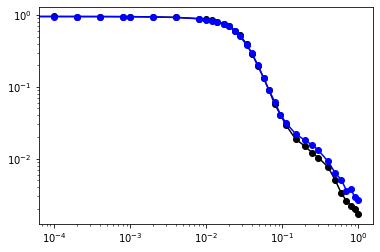

In [ ]:
import matplotlib.pyplot as plt

df1 = final_df_attack.query('data_key == "FGSM" & source_task == 6 & meta == 0.7 & hidden_per_layer == 1024 & beta_dq == 0e-4')
df2 = final_df_attack.query('data_key == "FGSM" & source_task == 6 & meta == 0.7 & hidden_per_layer == 1024 & beta_dq == 6e-4')

eps_vec = df1.epsilon.to_numpy()
acc_vec = df1.test_acc.to_numpy()/100.0
print(calc_auc_attack(eps_vec, acc_vec))
plt.plot(eps_vec, acc_vec, '-ko')

eps_vec = df2.epsilon.to_numpy()
acc_vec = df2.test_acc.to_numpy()/100.0
print(calc_auc_attack(eps_vec, acc_vec))

plt.plot(eps_vec, acc_vec, '-bo')
plt.xscale('log')
plt.yscale('log')

In [ ]:
def attack_robustness(df):
    acc = df['test_acc'].to_numpy()/100.0
    eps = df['epsilon'].to_numpy()
    auc_raw, auc_log = calc_auc_attack(eps, acc)
    return {'auc_raw':auc_raw, 'auc_log':auc_log}

final_df_attack_auc = final_df_attack.groupby(by=[
    'source_task','data_key','hidden_per_layer','meta','beta_dq'                          
]).apply(
    attack_robustness
).to_frame('_auc').reset_index()

final_df_attack_auc = pd.concat([
    final_df_attack_auc, 
    pd.json_normalize(final_df_attack_auc._auc)
], axis=1).drop(columns='_auc')

final_df_attack_auc

,source_task,data_key,hidden_per_layer,meta,beta_dq,auc_raw,auc_log
0,1,DDNAttack,1024,0.00,0.0000,0.015416,0.663951
1,1,DDNAttack,1024,0.00,0.0003,0.012423,0.633661
2,1,DDNAttack,1024,0.00,0.0006,0.015149,0.648531
3,1,DDNAttack,1024,0.70,0.0000,0.068270,0.801003
4,1,DDNAttack,1024,0.70,0.0003,0.075004,0.813248
...,...,...,...,...,...,...,...
463,6,LinfPGD,1024,1.35,0.0006,0.039763,0.740646
464,6,LinfPGD,4096,0.00,0.0000,0.077604,0.819876
465,6,LinfPGD,4096,0.00,0.0006,0.080923,0.802374
466,6,LinfPGD,4096,1.35,0.0000,0.045865,0.746398


In [ ]:
max(np.log(final_df_attack_auc.auc_raw))

-0.23802550023016214

In [ ]:
value_fields = ['auc_raw', 'auc_log']
radial_based_on_auctype = dict(
    auc_raw = dict(range=[-8, 0]),
    auc_log = dict(range=[-0.8, 0])
)

In [ ]:
for n_h, val_field in itertools.product(unq_H, value_fields):
    select_df = final_df_attack_auc.query('hidden_per_layer == @n_h')
    sel_cmap = cmap[::int((len(cmap)-1)/(len(select_df.beta_dq.unique())))]

    unq_tasks = select_df.source_task.unique()
    unq_betadq = select_df.beta_dq.unique()
    unq_meta = select_df.meta.unique()

    ncol = len(unq_tasks)
    nrow = len(unq_betadq)

    make_betadq_str = lambda x: '%.0e' %(x) if x > 0 else '0'
    fig = make_subplots(
            rows=nrow, cols=ncol,
            specs=[[{'type': 'polar'}]*ncol]*nrow,
            x_title='source of data',
            vertical_spacing=0.05,
            row_titles=[u"β" + '<sub>DQ</sub> = ' + make_betadq_str(x) for x in unq_betadq],

    )

    src = unq_tasks[-1]
    beta = unq_betadq[-1]
    meta = unq_meta[-1]
    ordered_keys = select_df\
                    .query('source_task==@src & beta_dq==@beta & meta==@meta')\
                    .sort_values(by=val_field, ignore_index=True, ascending=False)
    ordered_keys = ordered_keys.data_key.tolist()

    for irow, beta in enumerate(unq_betadq): 
        for icol, src in enumerate(unq_tasks):
            for k, meta in enumerate(unq_meta):
                sel_dat = select_df.query('source_task==@src & beta_dq==@beta & meta==@meta')
                sel_dat = sel_dat.set_index('data_key').loc[ordered_keys,val_field].tolist()
                fig.add_trace(
                    go.Scatterpolar(
                        r = np.log(sel_dat),
                        theta = ordered_keys,
                        line_color = sel_cmap[k],
                        line_width=4,
                        mode="lines",
                        legendgroup = meta,
                        name='%.2f' %(meta),
                        showlegend= irow+icol==0
                    ), 
                    irow+1, icol+1
                )

    polar_config = dict(
        bgcolor = 'white',
        radialaxis = dict(
            tickfont_size = 12,
            **radial_based_on_auctype[val_field],
            showline=True,
            linecolor='rgb(0, 0, 0)',
            gridcolor='rgb(220, 220, 220)',
        ),
        angularaxis = dict(
            tickfont_size=15,
            showline=True,
            linecolor='rgb(0, 0, 0)',
            gridcolor='rgb(220, 220, 220)',
        ),
    )

    for i in range(30): # for subplots
        id = str(i) if i > 0 else '' 
        id = 'polar' + id
        polar_dict = {id : polar_config}
        if i > 1: polar_dict[id]['angularaxis_showticklabels'] = False
        fig.update_layout(**polar_dict)

    fig.update_annotations(font_size=25)
                
    fig.update_layout(
        general_layout,
        width=1700,
        height=800,
        font_size = 20, 
        xaxis_title_font_size=10,
        title_font_size = 25,
        legend_title="meta",
        title_text='Adversarial attacks robustness log(%s) for H=%d' %(val_field, n_h),
    )

    fig_name =  'vary-meta-dq-advatck-%s-H=%04d' %(val_field, n_h)
    fig.write_image(fig_root / (fig_name + '.svg'))

    fig.show()